In [ ]:
from pathlib import Path
import sys

# --- Notebook bootstrap (works from repo root or notebooks/) ---
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / 'mm').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

DATA_ROOT = REPO_ROOT / 'data'
OUT_ROOT = REPO_ROOT / 'out'

print('REPO_ROOT:', REPO_ROOT)


# Calibration schedule QA\n\nThis notebook loads the outputs of **Mode B** (schedule-only calibration) and provides a small set of QA plots and diagnostics.\n\nExpected inputs (produced by `python -m mm.runner_calibrate_schedule`):\n- `poisson_schedule.json`\n- `window_metrics.csv`\n\nOptionally, it can also load the day’s market data (trades) to correlate parameters with regime metrics (trade rate / realized volatility proxies).\n

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- EDIT THESE ---
RUN_DIR = OUT_ROOT / 'calibration/schedules/BTCUSDT/20251223_20260111T230144Z'  # folder containing manifest.json
# DATA_ROOT is provided by the bootstrap cell
SYMBOL = 'BTCUSDT'
DAY = '20251223'


In [2]:
manifest_path = RUN_DIR / 'manifest.json'
if manifest_path.exists():
    manifest = json.loads(manifest_path.read_text(encoding='utf-8'))
    schedule_path = Path(manifest['schedule_path'])
    metrics_path = Path(manifest['window_metrics_csv'])
else:
    schedule_path = RUN_DIR / 'poisson_schedule.json'
    metrics_path = RUN_DIR / 'window_metrics.csv'

schedule = json.loads(schedule_path.read_text(encoding='utf-8'))
metrics_path = resolve_csv_path(Path(metrics_path))
df = pd.read_csv(metrics_path)

df['start_dt'] = pd.to_datetime(df['start_ms'], unit='ms', utc=True)
df['end_dt'] = pd.to_datetime(df['end_ms'], unit='ms', utc=True)
df['lambda_d1'] = df['A'] * np.exp(-df['k'] * 1)
df['lambda_d3'] = df['A'] * np.exp(-df['k'] * 3)
df['lambda_d8'] = df['A'] * np.exp(-df['k'] * 8)

display(df.head())
print('Segments:', len(df), 'usable_ratio:', float(df['usable'].mean()) if len(df) else None)



,start_ms,end_ms,A,k,usable,reason,train_start_ms,train_end_ms,calib_dir,dt_ms,tick_size,exposure_s_total,fills_total,n_deltas_usable,start_dt,end_dt,lambda_d1,lambda_d3,lambda_d8
0,1766480400120,1766481300120,0.718164,0.012115,True,OK,1766473200120,1766480400120,out/calibration/schedules/BTCUSDT/20251223_202...,100,0.01,12215.419,0,6,2025-12-23 09:00:00.120000+00:00,2025-12-23 09:15:00.120000+00:00,0.709516,0.692532,0.651828
1,1766481300120,1766482200120,0.787565,0.046437,True,OK,1766474100120,1766481300120,out/calibration/schedules/BTCUSDT/20251223_202...,100,0.01,12256.921,0,6,2025-12-23 09:15:00.120000+00:00,2025-12-23 09:30:00.120000+00:00,0.751829,0.685148,0.543185
2,1766482200120,1766483100120,0.706061,0.027372,True,OK,1766475000120,1766482200120,out/calibration/schedules/BTCUSDT/20251223_202...,100,0.01,12200.832,0,6,2025-12-23 09:30:00.120000+00:00,2025-12-23 09:45:00.120000+00:00,0.686997,0.650398,0.567206
3,1766483100120,1766484000120,0.708572,0.028553,True,OK,1766475900120,1766483100120,out/calibration/schedules/BTCUSDT/20251223_202...,100,0.01,12055.150,0,6,2025-12-23 09:45:00.120000+00:00,2025-12-23 10:00:00.120000+00:00,0.688627,0.650404,0.563874
4,1766484000120,1766484900120,0.658655,0.024929,True,OK,1766476800120,1766484000120,out/calibration/schedules/BTCUSDT/20251223_202...,100,0.01,11754.540,0,6,2025-12-23 10:00:00.120000+00:00,2025-12-23 10:15:00.120000+00:00,0.642438,0.611192,0.539566


Segments: 48 usable_ratio: 1.0


## Coverage and data quality
These plots answer: do we have enough usable segments, and are we frequently falling back?

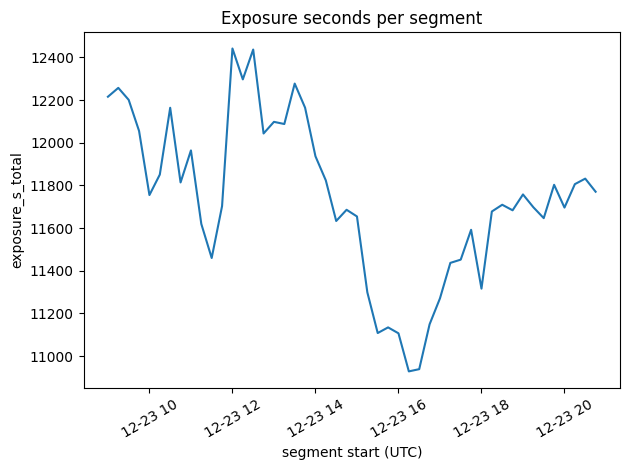

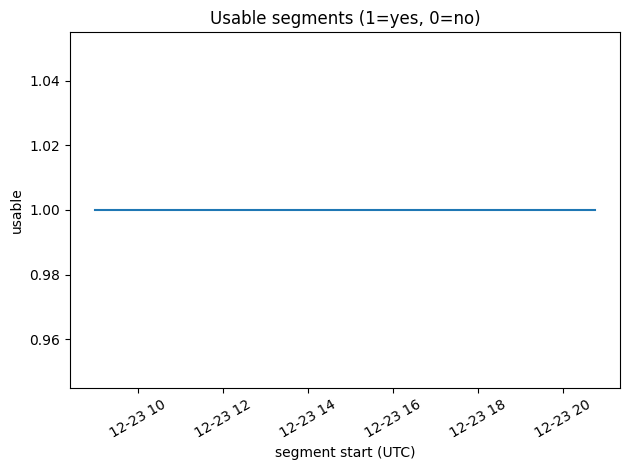

In [3]:
plt.figure()
plt.plot(df['start_dt'], df['exposure_s_total'])
plt.title('Exposure seconds per segment')
plt.xlabel('segment start (UTC)')
plt.ylabel('exposure_s_total')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df['start_dt'], df['usable'].astype(int))
plt.title('Usable segments (1=yes, 0=no)')
plt.xlabel('segment start (UTC)')
plt.ylabel('usable')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Parameter stability
A and k can be hard to interpret directly; implied λ(δ) at a few deltas is often more intuitive.

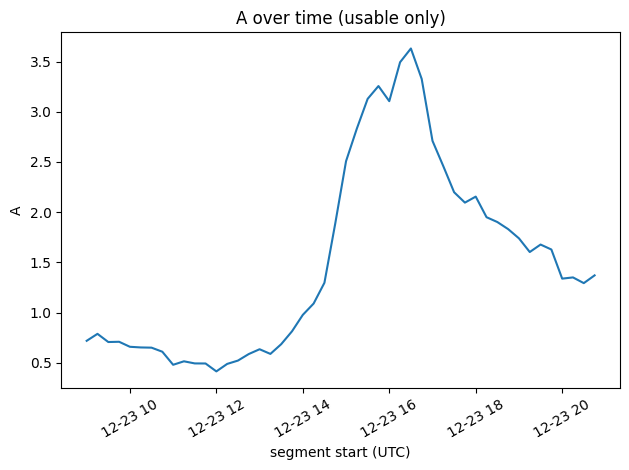

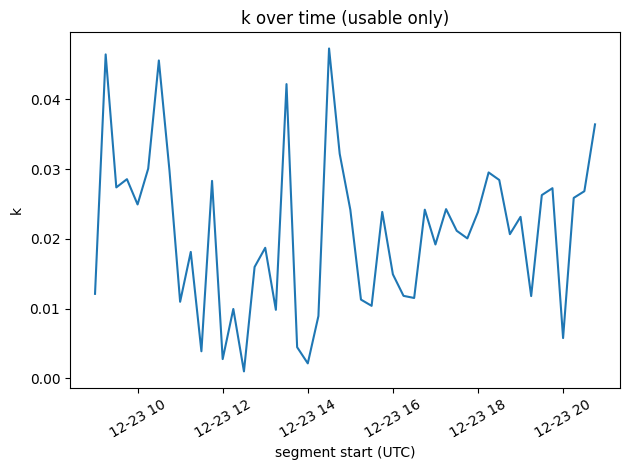

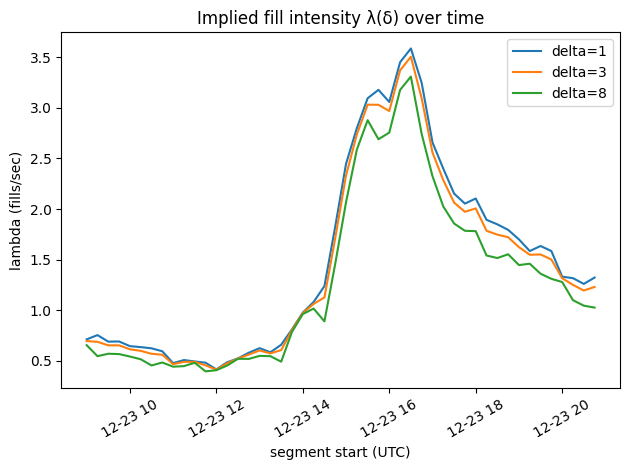

In [4]:
usable = df[df['usable'] == True].copy()

plt.figure()
plt.plot(usable['start_dt'], usable['A'])
plt.title('A over time (usable only)')
plt.xlabel('segment start (UTC)')
plt.ylabel('A')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(usable['start_dt'], usable['k'])
plt.title('k over time (usable only)')
plt.xlabel('segment start (UTC)')
plt.ylabel('k')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df['start_dt'], df['lambda_d1'], label='delta=1')
plt.plot(df['start_dt'], df['lambda_d3'], label='delta=3')
plt.plot(df['start_dt'], df['lambda_d8'], label='delta=8')
plt.title('Implied fill intensity λ(δ) over time')
plt.xlabel('segment start (UTC)')
plt.ylabel('lambda (fills/sec)')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Optional: correlate parameters with market regime (trade rate)
If you have trades for the day available locally, this provides a quick sanity check: A should loosely track trade activity / liquidity.

In [5]:
# Optional: load trades. This assumes your normal file layout and parsers.
try:
    from mm.backtest.io import find_trades_file, iter_trades_csv
    p = find_trades_file(DATA_ROOT, SYMBOL, DAY)
    rows = []
    for tr in iter_trades_csv(p):
        rows.append((int(tr.recv_ms), float(tr.price), float(tr.qty)))
    trades = pd.DataFrame(rows, columns=['recv_ms', 'price', 'qty'])
    trades['dt'] = pd.to_datetime(trades['recv_ms'], unit='ms', utc=True)
    print('Loaded trades:', len(trades), 'from', p)
except Exception as e:
    trades = None
    print('Could not load trades (optional):', repr(e))


Loaded trades: 2943824 from data/BTCUSDT/20251223/trades_ws_BTCUSDT_20251223.csv


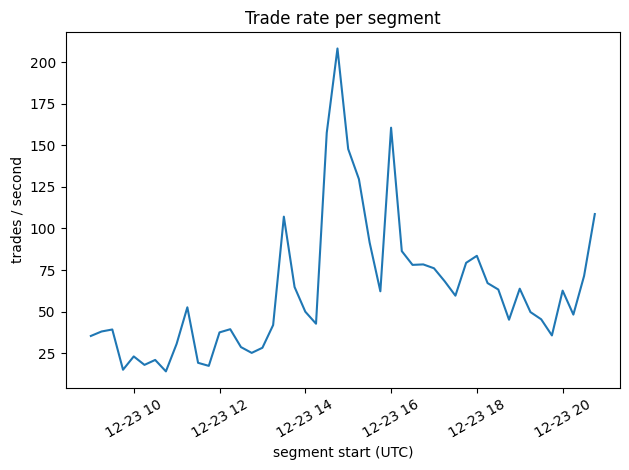

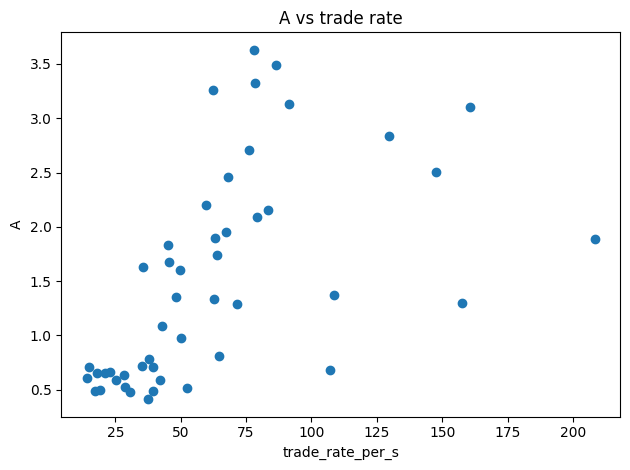

In [6]:
if trades is not None and len(trades):
    # Trade rate per segment
    seg_rates = []
    for _, r in df.iterrows():
        m = (trades['recv_ms'] >= r['start_ms']) & (trades['recv_ms'] < r['end_ms'])
        n = int(m.sum())
        dur_s = (r['end_ms'] - r['start_ms']) / 1000.0
        seg_rates.append(n / dur_s if dur_s > 0 else 0.0)
    df['trade_rate_per_s'] = seg_rates

    plt.figure()
    plt.plot(df['start_dt'], df['trade_rate_per_s'])
    plt.title('Trade rate per segment')
    plt.xlabel('segment start (UTC)')
    plt.ylabel('trades / second')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Simple correlation view
    plt.figure()
    plt.scatter(df['trade_rate_per_s'], df['A'])
    plt.title('A vs trade rate')
    plt.xlabel('trade_rate_per_s')
    plt.ylabel('A')
    plt.tight_layout()
    plt.show()
